# Issues with outliers

In the last subject, we fitted polynomials to different data sets using the polyfit() function, and we saw that it's minimizing the residual sum of squares (RSS) measure. In this unit, we will see that this process is sensitive to extreme points called outliers due to the nature of the RSS measure. At the end of this unit, you should have the necessary tools to detect and remove outliers using Numpy functions.

This time, we will work with a modified version of the marketing campaign data set in which we added five outliers.

In [1]:
import pandas as pd

data_df = pd.read_csv('marketing-outliers.csv')
data_df.shape


(55, 4)

In [2]:
# Last five data points
data_df.tail()

,tv,web,radio,sales
50,2.293,2.314,1.167,8.937
51,2.891,1.895,1.365,8.132
52,1.305,1.940,1.454,8.892
53,11.022,1.855,1.282,1.389
54,11.786,2.066,1.466,1.623


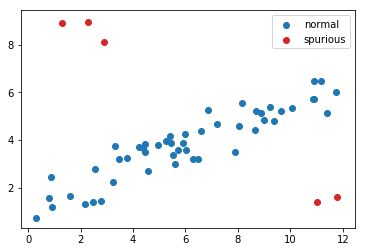

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

# Extract tv and sales
x = data_df['tv'].values
y = data_df['sales'].values

# Plot the data points
plt.scatter(x[:-5], y[:-5], label='normal')
plt.scatter(x[-5:], y[-5:], c='C3', label='spurious')
plt.legend()
plt.show()

Note that these outliers are not necessarily incorrect values. The difference could be due to a phenomenon that does not appear in our data, i.e., **unobserved variables.**

The problem with **outliers is that a few of them can have a significant effect on the final model.** To illustrate this issue, let's compare the coefficients of a linear regression on the entire data set with those from a linear regression fitted without the five outliers.

In [4]:
import numpy as np

# Fit a linear regression
coefs = np.polyfit(x, y, deg=1)
print('coefs:', coefs) 

# Fit a linear regression without the 5 outliers
coefs_wo = np.polyfit(x[:-5], y[:-5], deg=1)
print('coefs without outliers:', coefs_wo)

coefs: [0.20613307 2.76540858]
coefs without outliers: [0.42063597 1.27867727]


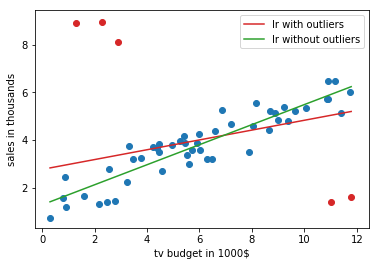

In [5]:
# Compute prediction line
x_values = np.linspace(min(x), max(x), num=100)
y_values = np.polyval(coefs, x_values)
y_values_wo = np.polyval(coefs_wo, x_values)

# Plot them
plt.scatter(x[:-5], y[:-5])
plt.scatter(x[-5:], y[-5:], c='C3')
plt.plot(x_values, y_values, c='C3', label='lr with outliers')
plt.plot(x_values, y_values_wo, c='C2', label='lr without outliers')
plt.xlabel('tv budget in 1000$')
plt.ylabel('sales in thousands')
plt.legend()
plt.show()

In [6]:
# Compute predictions for all data points
y_pred = np.polyval(coefs, x)

# Compute the squares of residuals
squares_residuals = np.square(y - y_pred)

print('RSS normal points:', np.sum(squares_residuals[:-5])) 
print('RSS outliers:', np.sum(squares_residuals[-5:])) 
print('RSS all points:', np.sum(squares_residuals))

RSS normal points: 39.533764623373486
RSS outliers: 115.61761647921125
RSS all points: 155.15138110258476


### Remove outliers by hand

In our example, we know that the issue comes from the tv and sales variables, and we can easily separate the outliers from the rest of the data points by defining two regions.

- Data points with an x value below 4 and a y value above 6. This corresponds to the upper left corner of the plot.
- Data points with an x value above 10 and a y value below 2. This corresponds to the lower right corner.

In [7]:
# Select outliers
idx = (((x < 4) & (y > 6)) | ((x > 10) & (y < 2)))

**Note that we need to write the parentheses in this expression due to the operator precedence mechanism in Python.** In short, operators in an expression are evaluated with a specific order. For instance, the & operator has a higher precedence than the < and > ones. Hence, this operator is evaluated before the two others and we get an error if we remove the parentheses.

In [8]:
np.logical_or(np.logical_and(x < 4, y > 6),
              np.logical_and(x > 10, y < 2))

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True])

In [9]:
# Extract "normal" points
x1, y1 = x[~idx], y[~idx]
print('x1/y1:', x1.shape, y1.shape)

# Extract outliers
x2, y2 = x[idx], y[idx]
print('x2/y2:', x2.shape, y2.shape)

x1/y1: (50,) (50,)
x2/y2: (5,) (5,)


**In this code, we use the bitwise complement ~ operator to invert the boolean values and select the "normal" points.**

In our example, we can identify and filter the outliers manually. However, this might be more complex in other cases. Also, defining these two regions is somehow arbitrary and we might want to have a more standard definition of what an outlier is. We are now going to see the standard score or z-score measure which quantifies how extreme a value is.

### Standard scores

Intuitively, an outlier is a value far from the other ones. The standard score formalizes this idea using two statistics: the mean 
μ
 and the standard deviation 
σ
.

Given a value 
x
, it measures how far it is from the center with 
(
x
−
μ
)
. Note that this quantity depends on the dispersion of the data. For instance, values that have a large spread will be further away from the mean than values with a smaller spread. For this reason, the z-score standardizes this distance by the standard deviation 
σ
 which quantifies the dispersion of the values.

In [10]:
# Compute z-scores
z_scores = (y - y.mean()) / y.std()

print('z-scores:', z_scores.shape) 

z-scores: (55,)


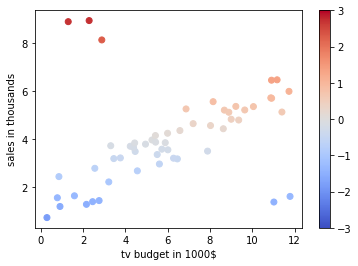

In [11]:
# Plot z-scores
plt.scatter(x, y, c=z_scores, cmap='coolwarm', vmin = -3, vmax = 3)
plt.xlabel('tv budget in 1000$')
plt.ylabel('sales in thousands')
plt.colorbar()
plt.show()

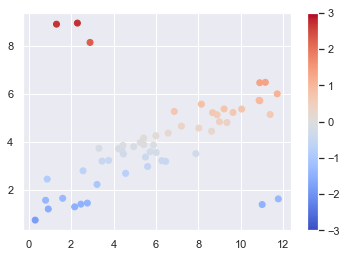

In [12]:
import seaborn as sns
import matplotlib.colors as colors

# Activate Seaborn style
sns.set()


# Plot z-scores
plt.scatter(x, y, c=z_scores, cmap=plt.cm.coolwarm,  norm=colors.Normalize(vmin=-3, vmax=3))
plt.colorbar()
plt.show()

We can now set the threshold on these scores. **We usually take the normal distribution as a point of reference to define this threshold.** For a variable that follows a normal distribution, this image shows the cumulative percentage which is the probability of being below a certain threshold.



In [13]:
# Select outliers
idx = (np.abs(z_scores) > 2)
idx

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True, False,
       False])

**This time, we only detected the three outliers in the top left corner of the image. Here is the idx mask.**

If we remove the outliers using the idx mask and fit a linear regression, we can see that the linear regression is very close to the one obtained by manually removing all the outliers.

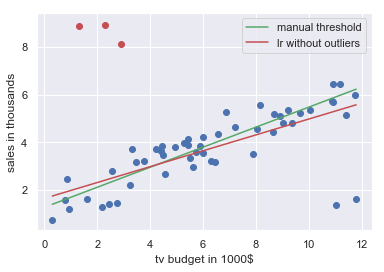

In [14]:
# Fit linear regression
coefs_z = np.polyfit(x[~idx], y[~idx], deg=1)

# Prediction line
y_values_zscore = np.polyval(coefs_z, x_values)

# Final comparison
plt.scatter(x[~idx], y[~idx])
plt.scatter(x[idx], y[idx], c='C3')
plt.plot(x_values, y_values_wo, c='C2', label='manual threshold')
plt.plot(x_values, y_values_zscore, c='C3', label='lr without outliers')
plt.xlabel('tv budget in 1000$')
plt.ylabel('sales in thousands')
plt.legend()
plt.show()

### Summary
Let's summarize what we've learned in this unit. Here are a few takeaways.

When minimizing the squared residuals (RSS), we need to be careful about outliers because the RSS measure amplifies their effect on our models

1) If possible, we should try to remove these outliers by hand

2) However, this is not always possible, and the process is somehow arbitrary. One solution is to set a threshold on the standard scores

3) In the next units, we will see two alternatives to the RSS measure that work better with outliers: the **mean absolute error (MAE) and Huber loss.**

# Mean absolute error

the polyfit() function minimizes the residual sum of squares (RSS) measure.These error metrics have many different names. For instance, we call them cost functions, loss functions or objective functions. The idea is that they associate a cost to each prediction 
^
y
i
 that we want to minimize.

The RSS metric is part of a class of cost functions that measure the squared errors. This category includes the MSE function that computes the mean of the squared errors and the RMSE function which is the square root of the MSE cost function. **It's important to understand that these measures are equivalent in the sense that we would get the same optimal parameters using the RSS, the MSE or the RMSE cost functions to fit our model. Hence, they have the same issues with outliers.**

An **alternative to these cost functions is the mean absolute error (MAE)** metric which measures the absolute values of the residuals.

We can see that both cost functions evaluate to zero when the predicted value is equal to the observed one. Also, they are symmetric and assign the same cost to a negative or a positive error of the same amplitude.

One difference is the rate at which they grow. The MSE cost function increases quadratically whereas the MAE one increases linearly. Hence, **the MAE metric works better with outliers since it doesn't overweight them. However, it's difficult to use this function in practice because it is not smooth around zero.** Its slope changes abruptly from -1 to +1 due to the absolute value which makes it harder to find the optimal parameters.

In summary, the **RSS-like and the MAE cost functions have both their advantages.** One is robust to outliers while the other is smooth. This is known as the statistical versus computational trade-off.

### Statistical vs. computational trade-off
The MAE function is robust to outliers which is a desired statistical property. However, it's not smooth. To illustrate the issue, we can compare the error surfaces of the MAE and MSE cost functions for an arbitrary data set.

Let's start with the error surface of the MAE cost function.

#### See 3-2-2

As you can see, **the error surface is a set of planes that intersect each other which makes it difficult for optimization algorithms to find the optimal parameters. For instance, we will see later in this course the gradient descent method that "walks down" on this error surface by following the direction of the steepest descent.** In this case, it's difficult for the algorithm to find the optimal solution since it "jumps" from one plane to the others.

This problem doesn't occur with the MSE cost function.

We say that smoothness is a **computational property** because it makes computations easier. Later in this course, we will talk about **convexity** which is another desired computational property because it ensures that optimization algorithms **such as gradient descent don't get stuck in local optimum.**

### Summary
Let's summarize what we've learned in this unit. Here are a few takeaways.

- When fitting a model, we optimize a cost/loss/objective function
- The MAE is robust to outliers which is a nice statistical property but is difficult to optimize because it's not smooth.
- MAE is easy to interpret. For instance, a score of 3 means that the predictions are, in average, above or below the observed value by a distance of 3.

In the next unit, we will learn about the **Huber loss** which combines the two properties from above. Also, we will see how to fit a model using this cost function with **Scikit-learn.**

# Huber loss

We will now learn about the Huber loss which is a way to combine the RSS and MAE cost functions. At the end of this unit, you should be able to fit models with this objective function using objects from the Scikit-learn library.

**Huber loss is a cost function which is robust to outliers and smooth. In fact, its formula uses both the absolute value and the square function.**

In our case, the variable 
e
 refers to the residual 
e
=
(
y
−
^
y
)
 and 
L
(
e
)
 is the loss value of a single data point. The formula defines two cases using a threshold 
δ
 (delta).

When the magnitude of the residual is below 
δ
 (small error), the function increases quadratically like the RSS one and then, for larger errors, linearly like the MAE one. The 
δ
 value determines when the function becomes linear. Here is a plot of the Huber loss with different threshold values.
 
 As we can see, the 
δ
 value controls the **robustness to outliers.** For instance, a Huber loss function with 
δ
=
0.5
 is less sensitive to outliers than one with 
δ
=
1.5
. Also, the function is **smooth** in the sense that its derivative is continuous. The slope of the curve is 
e
 below the threshold and 
±
δ
 above it.

### Implementation with SGDRegressor
In practice, it's a good idea to try to use the Huber loss if there are outliers in the data. Let's test it on our modified marketing campaign data set

In [15]:
import pandas as pd
from sklearn.preprocessing import scale

# Load data
data_df = pd.read_csv('marketing-outliers.csv')
x = scale(data_df['tv'].values)
y = data_df['sales'].values

Here, we load the TV vs. Sales data and **rescale** the input data with the scale() function. We will come back to this point later, **but in short, some algorithms like the one that we will use in this unit require the data to be preprocessed in this way.**

The Numpy polyfit() function doesn't implement Huber loss. Hence, we will now switch to the **Scikit-learn library which provides many machine learning models.** The workflow is a bit different with this library. Instead of calling functions directly, **we create objects that we fit to data sets.**

Let's start with the SGDRegressor object. First, we need to import it from the linear_model module from Scikit-learn.


In [16]:
from sklearn.linear_model import SGDRegressor

The name of the object comes from the optimization algorithm that it uses to find the optimal parameters. The SGDRegressor object implements the **stochastic gradient descent (SGD)** algorithm which is a very generic algorithm that can minimize a great variety of cost functions. For this reason, the object has many parameters.

By default, it minimizes the square of the residuals plus a **penalization term.** This additional term is useful to fight **overfitting,** but we will learn more about it later in this course. As for now, let's remove it by setting penalty='none'. We can then change the loss function to Huber with loss='huber' and set the threshold value 
δ
 with the epsilon parameter.

In [17]:
# Create a linear regression with Huber loss
lr_huber = SGDRegressor(loss='huber', penalty='none', epsilon=1, max_iter=1000, tol=1e-3)

SGD is an **iterative algorithm** that tries to minimize the objective function by taking small steps in the direction of the optimal solution. For this reason, we need to specify when it stops. With the code from above, SGD stops when the loss stops improving (tol parameter) or when it reaches some maximum number of iterations (max_iter one). Regarding the values, we simply use the defaults, recommended ones from Scikit-learn.

We can now fit the model to the data with its fit() function.

In [18]:
import numpy as np

# Fit the model
lr_huber.fit(x[:, np.newaxis], y);

**In machine learning, data sets usually have several features. For this reason, Scikit-learn objects expect to get a 2-dimensional array of features**. In our case, the x variable is a vector with shape (55,), but we can convert it to a matrix of shape (55,1) by adding a new axis with the [:, np.newaxis] syntax.

In [19]:
# Print the slope of the line
print('Slope:', lr_huber.coef_)

# Print the intercept parameter
print('Intercept term:', lr_huber.intercept_)


Slope: [1.12470995]
Intercept term: [3.78637545]


If you run the fit() instruction from above several times and print the parameters, you should see that they vary slightly between each run. This is due to the **stochastic nature of the SGD algorithm.**
We will learn more about the gradient descent algorithm later in this course, but in short, its stochastic version (SGD) **optimizes the loss function by picking a random data point at each iteration.** For this reason, we say that the algorithm is stochastic because the results depend on these random choices.

We can now visualize our linear regression by generating a hundred data points between min(x) and max(x) with the Numpy linspace() function. We could use the Numpy polyval() function to compute predictions, but Scikit-learn objects also have a predict() function that uses the values in the coef_ and the intercept_ attributes

In [20]:
# Compute prediction line
x_values = np.linspace(min(x), max(x), num=100) # Shape (100,)
y_values_huber = lr_huber.predict(
    x_values[:, np.newaxis] # Shape (100,1)
)
# Again, we need to add a dimension to the x_values vector since Scikit-learn works with 2-dimensional arrays of features. Let's plot the prediction line

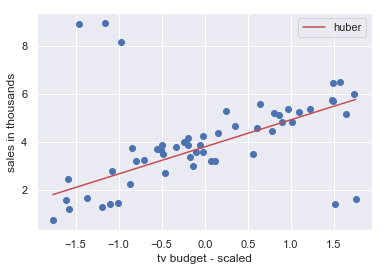

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot predictions
plt.scatter(x, y)
plt.plot(x_values, y_values_huber, c='C3', label='huber')
plt.xlabel('tv budget - scaled')
plt.ylabel('sales in thousands')
plt.legend()
plt.show()

As we can see, the line fits well the trend in the data points. Now, let's compare this line to the one that we get when minimizing the squares of the residuals, e.g., **as with the polyfit() function. To achieve this, we can simply change the loss parameter to squared_loss**

In [22]:
# Create a linear regression with RSS loss
lr_squared = SGDRegressor(loss='squared_loss', penalty='none', max_iter=1000, tol=1e-3)

In [23]:
# Fit the model
lr_squared.fit(x[:, np.newaxis], y)    # polyfit()

# Compute prediction line
y_values_squared = lr_squared.predict(x_values[:, np.newaxis])

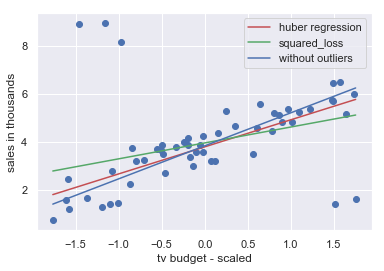

In [24]:
# Linear regression without outliers
coefs = np.polyfit(
    x[:-5], y[:-5], # Filter outliers (the last five values)
    deg=1
)
y_values_optimal = np.polyval(coefs, x_values)

# Compare models
plt.scatter(x, y)
plt.plot(x_values, y_values_huber, c='C3', label='huber regression')
plt.plot(x_values, y_values_squared, c='C2', label='squared_loss')
plt.plot(x_values, y_values_optimal, c='C0', label='without outliers')
plt.xlabel('tv budget - scaled')
plt.ylabel('sales in thousands')
plt.legend()
plt.show()

We can see that the model obtained by minimizing the **Huber loss is very close to the one that we get with the polyfit() function after removing the five outliers.**

### HuberRegressor

**Note that the SGDRegressor object is very generic and can fit more cost functions than the Huber and RSS ones. However, Scikit-learn also provides the HuberRegressor object which is dedicated to this loss function.**

It works similarly to SGDRegressor. You can fit it to data using the fit() function and compute predictions with the predict() one

In [25]:
from sklearn.linear_model import HuberRegressor

# Create a linear regression with Huber loss
lr_huber = HuberRegressor(epsilon=1.35)

# Fit the model
lr_huber.fit(x[:, np.newaxis], y);

Note that there are a few notable differences with the SGDRegressor(loss='huber') object

- The threshold 
δ
 depends on the scale of the residuals. The HuberRegressor implements a mechanism to make it scale invariant. The default value of epsilon=1.35 should work well in most cases.
- They use a different optimization algorithm. The SGDRegressor object uses stochastic gradient descent (SGD) while the HuberRegressor object uses the BFGS one. In short, BFGS should be more efficient when there is a small number of samples and converge in fewer iterations to the optimal solution. The default value for the number of iterations max_iter=100 should be fine in most cases.
### Summary
Let's summarize what we've learned in this unit. Here are a few takeaways

- Ideally, we want to use cost functions that are robust to outliers and easy to optimize
- The RSS one is smooth but sensitive to outliers
- The MAE one is robust but difficult to optimize
- The Huber loss combines both advantages of the RSS and MAE cost functions but adds a new parameter: the threshold 
δ

In practice, if you believe that there are outliers in the data, then it's a good idea to spend some time removing them using the techniques from the previous lessons. **Then, it's easy to test several models and pick the best one. We will learn more about model evaluation later in this subject.**

In the next exercise, you will work on a data set with outliers, and you will fit a linear regression with the Huber loss.

# Challenge - Fit polynomial
As an optional challenge, let's use our Huber regression object to fit a polynomial of degree three.

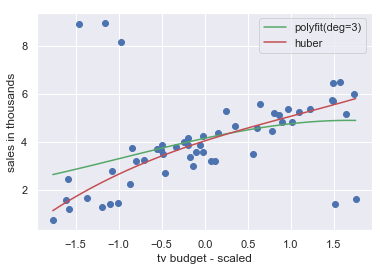

In [26]:
# Fit a polynomial of degree 3
X_poly = np.c_[x, x**2, x**3] # Feature engineering
lr_huber.fit(X_poly, y)

# Same with polyfit
coefs = np.polyfit(x, y, deg=3)

# Compute prediction line
x_values = np.linspace(min(x), max(x), num=100)
y_values_polyfit = np.polyval(coefs, x_values)
y_values_huber = lr_huber.predict(
    np.c_[x_values, x_values**2, x_values**3])

# Plot it
plt.scatter(x, y)
plt.plot(x_values, y_values_polyfit, c='C2', label='polyfit(deg=3)')
plt.plot(x_values, y_values_huber, c='C3', label='huber')
plt.xlabel('tv budget - scaled')
plt.ylabel('sales in thousands')
plt.legend()
plt.show()

# Introduction to model evaluation

In the last units, we learned more about the process of fitting a model. We saw that functions such as the polyfit() one or objects like SGDRegressor or HuberRegression use an optimization algorithm to **find the model parameters that minimize a cost function.**

We will now see how to **use these error metrics to compare models.** Also, we will learn about baseline models and see how to implement them using Numpy and Scikit-learn. At the end of this unit, you should know how to compare your models to a meaningful baseline.

This time, we will work on a modified version of the bike sharing dataset from the UCI repository which contains predictions from three different models that we want to compare.

In [28]:
import pandas as pd

# Load data
data_df = pd.read_csv('three-models.csv')
data_df.head()

,temp,users,pred_lr,pred_poly3,pred_huber3
0,0.1508,41,146,44,51
1,0.1609,54,161,53,52
2,0.1727,25,178,66,55
3,0.1775,75,185,72,57
4,0.1822,74,192,78,60


We obtained the first two models with the polyfit() function by setting its degree to 1 for the simple linear regression predictions pred_lr and to 3 for pred_poly3. The last predictions **pred_huber3 correspond to a polynomial of degree three fitted using the HuberRegressor and the PolynomialFeatures** objects from Scikit-learn. But we will learn about it later in this course.

It's important to understand that we fitted these models on another set of temperature and users values. In fact, to generate these predictions, we separated the 302 data points from the original data set into two sets of 151 points.

- A train set that we used to fit the models
- A test set that we used to evaluate the models. In our example, the data_df variable contains the data points and predictions for this set.

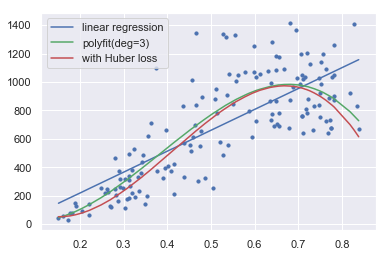

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

# Extract variables
x = data_df.temp.values
y = data_df.users.values

# Plot the models
plt.scatter(x, y, s=10)
plt.plot(x, data_df.pred_lr, c='C0', label='linear regression')
plt.plot(x, data_df.pred_poly3, c='C2', label='polyfit(deg=3)')
plt.plot(x, data_df.pred_huber3, c='C3', label='with Huber loss')
plt.legend()
plt.show()

It's difficult to compare the three models visually. One solution is to use a cost function such as the RSS one. In practice, we prefer to use the root mean squared error (RMSE) since it's independent of the number of data points (i.e., it's an average) and has roughly the same unit as the target variable.

In [30]:
import numpy as np

# Root mean squared error
def RMSE(y, y_pred):
    mse = np.mean(np.square(y - y_pred)) # MSE
    return np.sqrt(mse) # RMSE

rmse_lr = RMSE(y, data_df.pred_lr)
rmse_poly3 = RMSE(y, data_df.pred_poly3)
rmse_huber3 = RMSE(y, data_df.pred_huber3)

# Print values
print('linear regression:', rmse_lr)
print('polyfit(deg=3):', rmse_poly3) 
print('with huber loss:', rmse_huber3) 

linear regression: 232.53050786099598
polyfit(deg=3): 210.55145192395318
with huber loss: 215.66518077491205


According to this measure, the poly3 and the huber3 models have a better performance than the simple linear regression one, and the poly3 one performs slightly better than huber3.

Note that we can use any cost function. **For instance, we can compare the three models using the mean absolute error (MAE).**

In [31]:
import numpy as np

# Mean absolute error
def MAE(y, y_pred):
    return np.mean(np.abs(y - y_pred))

mae_lr = MAE(y, data_df.pred_lr)
mae_poly3 = MAE(y, data_df.pred_poly3)
mae_huber3 = MAE(y, data_df.pred_huber3)

# Print values
print('linear regression:', mae_lr) 
print('polyfit(deg=3):', mae_poly3) 
print('with huber loss:', mae_huber3)

linear regression: 186.58278145695365
polyfit(deg=3): 161.71523178807948
with huber loss: 164.75496688741723


**The advantage of MAE is that it has a clear interpretation. For instance, in our example, predictions from the poly3 model are wrong by, in average, 162 users. Note that MAE and RMSE are different cost functions. Hence, they might not agree on what is the best model.**

It would be interesting to compare our models against a baseline model that acts as a reference point, .i.e, a model that doesn't depend on the patterns that appear in the data. In our example, the linear regression model doesn't fulfill this role since it performs better when there is a linear relationship in the data.

One solution is to use the mean or the median of the target variable. Let's do a small experiment to see when it makes sense to use these two statistics as baselines

### Median versus mean

Which statistic should we use? In fact, both are good summaries of a set of values. They simply minimize different measures. The mean value optimizes the squares of the distances to the other values, whereas the median minimizes the absolute distances.

Let's do a little experiment to verify that. We define a set of values and search for its optimal summary. For instance, let's find the best summary of the set [1, 2, 3, 5, 6, 25] according to the MSE function. We can take one hundred values between 0 and 25 and treat them as candidate summaries. Here is the plot of the MSE cost function for these candidates.

**To summarize, it makes sense to use the mean as a baseline when we measure the squares of the residuals, e.g., RSS, MSE and RMSE cost functions. On the other hand, we should use the median as the baseline when we measure absolute distances like with the MAE cost function.**

In [34]:
# Compute baseline
pred_baseline = np.mean(y)
rmse_baseline = RMSE(y, pred_baseline)
rmse_baseline

371.11459394676217

*Note: In general, we should never fit a model to the test set, even the baseline - the test data should remain unseen before evaluation. So, ideally, we should compute pred_baseline using the average number of users on the train set. But since bike-sharing-three-models.csv doesn't contain the train data, we simply estimate this average on the test set with np.mean(y) which shouldn't be far from the results obtained on the train set.*

Note that pred_baseline is a single value and not an array like y. However, we can use the RMSE() function from above because it computes the residuals with (y-y_pred) which produces an array even if y_pred is a single value due to broadcasting.

If you want to produce a vector of predictions, you can create an array with the same shape as y and fill it with the mean value using the Numpy full_like() function.

In [35]:
# Vector with predictions from the baseline
pred_baseline = np.full_like(y, fill_value=np.mean(y), dtype=np.float)
pred_baseline

array([674.7218543, 674.7218543, 674.7218543, 674.7218543, 674.7218543,
       674.7218543, 674.7218543, 674.7218543, 674.7218543, 674.7218543,
       674.7218543, 674.7218543, 674.7218543, 674.7218543, 674.7218543,
       674.7218543, 674.7218543, 674.7218543, 674.7218543, 674.7218543,
       674.7218543, 674.7218543, 674.7218543, 674.7218543, 674.7218543,
       674.7218543, 674.7218543, 674.7218543, 674.7218543, 674.7218543,
       674.7218543, 674.7218543, 674.7218543, 674.7218543, 674.7218543,
       674.7218543, 674.7218543, 674.7218543, 674.7218543, 674.7218543,
       674.7218543, 674.7218543, 674.7218543, 674.7218543, 674.7218543,
       674.7218543, 674.7218543, 674.7218543, 674.7218543, 674.7218543,
       674.7218543, 674.7218543, 674.7218543, 674.7218543, 674.7218543,
       674.7218543, 674.7218543, 674.7218543, 674.7218543, 674.7218543,
       674.7218543, 674.7218543, 674.7218543, 674.7218543, 674.7218543,
       674.7218543, 674.7218543, 674.7218543, 674.7218543, 674.7

In [37]:
from sklearn.dummy import DummyRegressor

# Create the DummyRegressor object
dummy = DummyRegressor(strategy='mean')

Just like SGDRegressor and HuberRegressor, the DummyRegressor object implements the Scikit-learn estimator interface which means that it provides the fit() and predict() functions.

In [38]:
# Fit the estimator
dummy.fit(x[:, np.newaxis], y);

In [39]:
# Vector with predictions from the baseline
pred_baseline = dummy.predict(x[:, np.newaxis])

rmse_baseline = RMSE(y, pred_baseline)
rmse_baseline

371.11459394676217

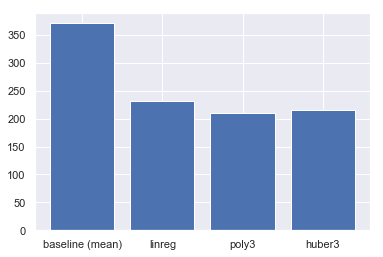

In [40]:
# Bar chart
plt.bar([1, 2, 3, 4], [rmse_baseline, rmse_lr, rmse_poly3, rmse_huber3])
plt.xticks([1, 2, 3, 4], ['baseline (mean)', 'linreg', 'poly3', 'huber3'])
plt.show()

### Summary
Let's summarize what we've learned in this unit.

- In a typical machine learning workflow, we fit models to data points from a train set and evaluate them on a test set
- The mean and median values are both good baselines. One minimizes the squares of the residuals while the other their absolute values
- Scikit-learn provides a DummyRegressor object to create baseline models

In practice, data sets usually have several features, and it's difficult to visually "see" how well do our models fit the data. For this reason, setting a baseline and comparing many different models can help in two ways.

1- To verify that our code works, i.e., a model that performs worse than the baseline is a sign that something is wrong
2- To choose an appropriate model, i.e., the model with the best accuracy isn't necessarily the most appropriate one. We might consider other aspects such as speed and interpretability of the model

In the next exercise, you have the opportunity to test all the models that you've learned so far on the entire bike sharing data set (731 data points) and compare them with a baseline model.


# Exercise - Bike sharing model evaluation  (ex: 3-2-6)